# **CMPE 257 Project Milestone 2**
## **Team 8**

# **LSTM With Future Value Prediction**

**Importing all required libraries**

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf

from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

import plotly.express as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)

**Preprocessing the data and parsing the date column for LSTM Future Predictions**

In [6]:
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('WHO-COVID-19-global-data.csv', parse_dates=[0], index_col=0, date_parser=parser)
df.dtypes
df.index.inferred_type == "datetime64"
df.tail()

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2022-10-24,ZW,Zimbabwe,AFRO,0,257893,0,5606
2022-10-25,ZW,Zimbabwe,AFRO,0,257893,0,5606
2022-10-26,ZW,Zimbabwe,AFRO,0,257893,0,5606
2022-10-27,ZW,Zimbabwe,AFRO,0,257893,0,5606
2022-10-28,ZW,Zimbabwe,AFRO,0,257893,0,5606


In [7]:
df = df.loc[df['Country'] == 'India']

In [8]:

df = df[['Cumulative_cases']]
df.tail()

,Cumulative_cases
Date_reported,
2022-10-24,44644076
2022-10-25,44644938
2022-10-26,44645768
2022-10-27,44646880
2022-10-28,44649088


**Scaling the data using MinMaxScaler() from sklearn library**

In [9]:
from sklearn.preprocessing import MinMaxScaler

train = df
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [10]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

**Creating the model and adding a dropout layer**

In [11]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
history = model.fit_generator(generator,epochs=100)

Epoch 1/100
170/170 [==============================] - 6s 22ms/step - loss: 0.0225
Epoch 2/100
170/170 [==============================] - 4s 21ms/step - loss: 0.0021
Epoch 3/100
170/170 [==============================] - 4s 21ms/step - loss: 0.0026
Epoch 4/100
170/170 [==============================] - 4s 21ms/step - loss: 0.0030
Epoch 5/100
170/170 [==============================] - 4s 22ms/step - loss: 0.0021
Epoch 6/100
170/170 [==============================] - 4s 22ms/step - loss: 0.0020
Epoch 7/100
170/170 [==============================] - 4s 23ms/step - loss: 0.0020
Epoch 8/100
170/170 [==============================] - 4s 22ms/step - loss: 0.0039
Epoch 9/100
170/170 [==============================] - 4s 22ms/step - loss: 0.0017
Epoch 10/100
170/170 [==============================] - 4s 21ms/step - loss: 0.0017
Epoch 11/100
170/170 [==============================] - 4s 22ms/step - loss: 0.0014
Epoch 12/100
170/170 [==============================] - 4s 22ms/step - loss: 0.0014
E

**Creating a pred_list to store predicted future values**

In [12]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [13]:
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [14]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
df_proj = pd.concat([df,df_predict], axis=1)

In [15]:
df_proj

,Cumulative_cases,Prediction
2020-01-03,0.0,NaN
2020-01-04,0.0,NaN
2020-01-05,0.0,NaN
2020-01-06,0.0,NaN
2020-01-07,0.0,NaN
...,...,...
2023-06-28,NaN,4.424673e+07
2023-07-28,NaN,4.420835e+07
2023-08-28,NaN,4.417082e+07
2023-09-28,NaN,4.413418e+07


**Plotting the Training data and the predicted values**

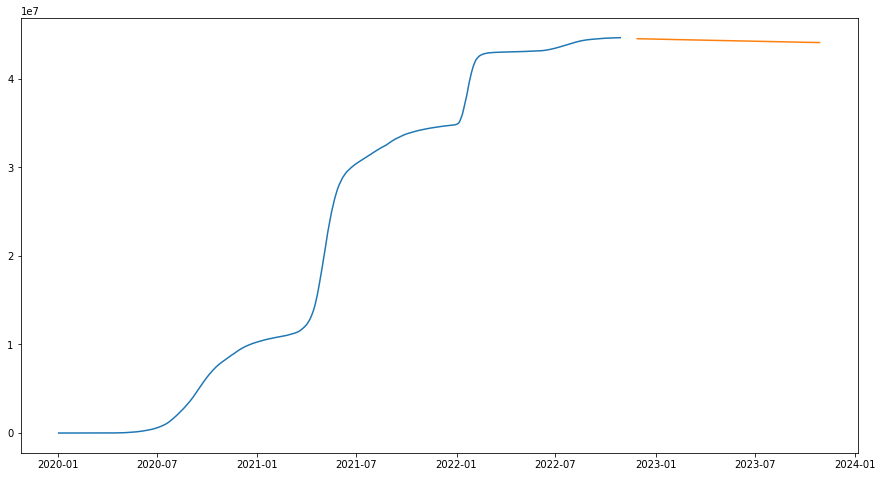

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,8))

  
plt.plot(df_proj.index, df_proj['Cumulative_cases'])  # Plot the chart
plt.plot(df_proj.index, df_proj['Prediction'], label = "line 2")

plt.show()  # display